# Sequential Bayesian Learning (SBL)
## Authors:  Author: Robert Tjarko Lange, Miro Grundei, Sam Gjisem
## Last Update: December 2018

# 0. General Introduction to the project

In this project we investigate the theoretical modelling of mismatch-negativity in the human somatosensory cortex. More specifically, we study a novel roving paradigm which is generated from a structured graphical model. This allows us to define standard and deviant stimuli in stimulus-feature-independent manner. Furthermore, sampling (as opposed to deterministic sequence generation) enables us to control for sequence-dependent cofounding factors.

The following notebook is structured as follows:

- ** 1. Generation of Trial Sequences based on Graphical Model**.
    * We formulate a general Markov model which generates a sequence of trials (0 - low intensity, 0.5 - catch trial, 1 - high intensity)
    * The alternation probability between different observations depends upon the previous observed states as well as the hidden state/regime which is modeled as a Markov Chain.
    * We are able to increase the order of the Markov dependency in the data-generating process. This allows to vary the complexity of the sequence generation.
    
    
- **2. Modeling of different Sequential Bayesian Learning Agents**.
    * The agents process the trial sequence as it comes in. Based on different probabilistic models they update there current posterior estimate about the hidden state that drives the sampling of the observed state. 
    * Based on her current posterior estimate, we can calculate different surprise measures (e.g. Predictive, Bayesian as well as Confidence-Corrected). These surprise measures indicate how well the agent is able to infer the data-generating mechanism and the corresponding hidden states.
    * Going forward we will combine the data-generating paradigm and surprise measures with frequency data obtained from an EEG study. Thereby, we will be able to compare different models with different degrees of complexity of somatosensory adaptation and learning.
    
    
- **3. Model Comparison across Different SBL Agents and Surprise Regressors**
    * Evaluation of theoretical models in explaining the EEG frequency variation.

In [1]:
!pip install -r requirements.txt --quiet

  Could not find a version that satisfies the requirement ipykernel==5.1.0 (from -r requirements.txt (line 8)) (from versions: 4.0.1, 4.0.2, 4.0.3, 4.1.0, 4.1.1, 4.2.0, 4.2.1, 4.2.2, 4.3.0, 4.3.1, 4.4.0, 4.4.1, 4.5.0, 4.5.1, 4.5.2, 4.6.0, 4.6.1, 4.7.0, 4.8.0, 4.8.1, 4.8.2, 4.9.0, 4.10.0)
No matching distribution found for ipykernel==5.1.0 (from -r requirements.txt (line 8))


In [6]:
# Import relevant sampling modules
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import numpy as np

from utils.helpers import *
import sampling.seq_gen as sg
import sampling.seq_analysis as sa

# Set random seed for replicability and define directories
np.random.seed(seed=1234)
results_dir = os.getcwd() + "/results/"
fig_dir = os.getcwd() + "/figures/"
data_dir = os.getcwd() + "/data/"

# 1. Generation of Trial Sequence based on Graphical Model

Our sampling paradigm is motivated by the classical roving paradigm. In such a setting a deviant is defined relative to the previous trials.

Depending on whether or not we account for second order Markov dependency also $o_{t-2}$ influences the sampling probabilities. Our generating process can be described by the following graphical model:

<img src="pics/gm_seq_gen.png" alt="drawing" width="750"/>

* Catch: $p(o_t = 0.5) = 0.05$
* Regime switch: $p(s_t \neq s_{t-1}) = 0.01$

Sample a sequence from the Graphical Model and saves it to .mat file
* 1st order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, s_t=0), p(o_t = 1|o_{t-1}=0, s_t=0)$
    * Regime 1: $p(o_t = 0|o_{t-1}=0, s_t=1), p(o_t = 1|o_{t-1}=0, s_t=1)$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 1 -v -seq
800
```

* 2nd order Markov sequence of length 800 with following probabilities:
    * Regime 0: $p(o_t = 0|o_{t-1}=0, o_{t-1}=0) = 0.35, p(o_t|o_{t-1}) = 0.65$
    * Regime 1: $p(o_t = 0|o_{t-1}=0) = 0.65, p(o_t|o_{t-1}) = 0.35$
```
pythonw seq_gen.py -t 1st_temp -reg_init 0.5 -reg_change 0.01 -catch 0.05 -obs_init 0.5 -obs_change 0.35 0.65 0.65 0.35 -order 2 -v -seq
800
```

In [21]:
# Define parameters for sequence sampling
prob_regime_init = np.array([0.5, 0.5])  # Prob. vector for inital regime (hidden state)
prob_regime_change = 0.01  # Prob. of sampling a regime change
prob_obs_init = np.array([0.5, 0.5, 0])  # Prob. vector for inital trial/stimulus (observed state)
prob_obs_change = [0.45, 0.45, 0.05, 0.05, 0.05, 0.05, 0.45, 0.45]  # Prob. matrix for different regimes
prob_catch = 0.05  # Prob. of sampling a catch trial (independent of hidden state)

order = len(prob_obs_change)/4  # Markov order/lag dependency in the sampling scheme
seq_length = 200  # Length of sampled sequence
sample_file = "S1_200"  # Title of file saved
matlab_out = True  # Boolean - store file as .mat - otherwise .pkl file
plot_seq = True  # Booelean - plot the sampled sequence
verbose = True  # Print out the transition prob. specification and empirical statistics of the sampled seq
plot_seqs = True

In [22]:
# Create instance of sampling class
gen_temp = sg.seq_gen(order, prob_catch, prob_regime_init, prob_regime_change,
                      prob_obs_init, prob_obs_change, verbose)

All input arrays conform with the specified dimensions.
HHMM correctly initialized. Ready to Sample.
--------------------------------------------
2nd Order Transition Prob. 
 Regime 0: p(0|00)=0.45, p(0|01)=0.45, p(0|10)=0.05,  p(0|11)=0.05 
 Regime 1: p(0|00)=0.05, p(0|01)=0.05, p(0|10)=0.45,  p(0|11)=0.45
--------------------------------------------


Empirical Probabilities: 
 Empirical Catch Prob.: 0.03 
 Empirical Regime Switch Prob.: 0.005 
 Empirical Overall High-Intensity Stimulus Prob.: 0.865979381443299 
 Empirical Regime 0 High-Intensity Stimulus Prob.: 0.935251798561151 
 Empirical Regime 1 High-Intensity Stimulus Prob.: 0.6909090909090909 
 Empirical Regime 0 Alternation Prob.: 0.09352517985611511 
 Empirical Regime 1 Alternation Prob.: 0.6545454545454545  
 JS Div. Deviant Waiting Time Distr. between Regimes: 0.3898516717012721 
 Time in Regime 0: 0.695 
 Average Train Length in Regime 0: 10.0 
 Average Train Length in Regime 1: 1.4864864864864864
--------------------------------------------


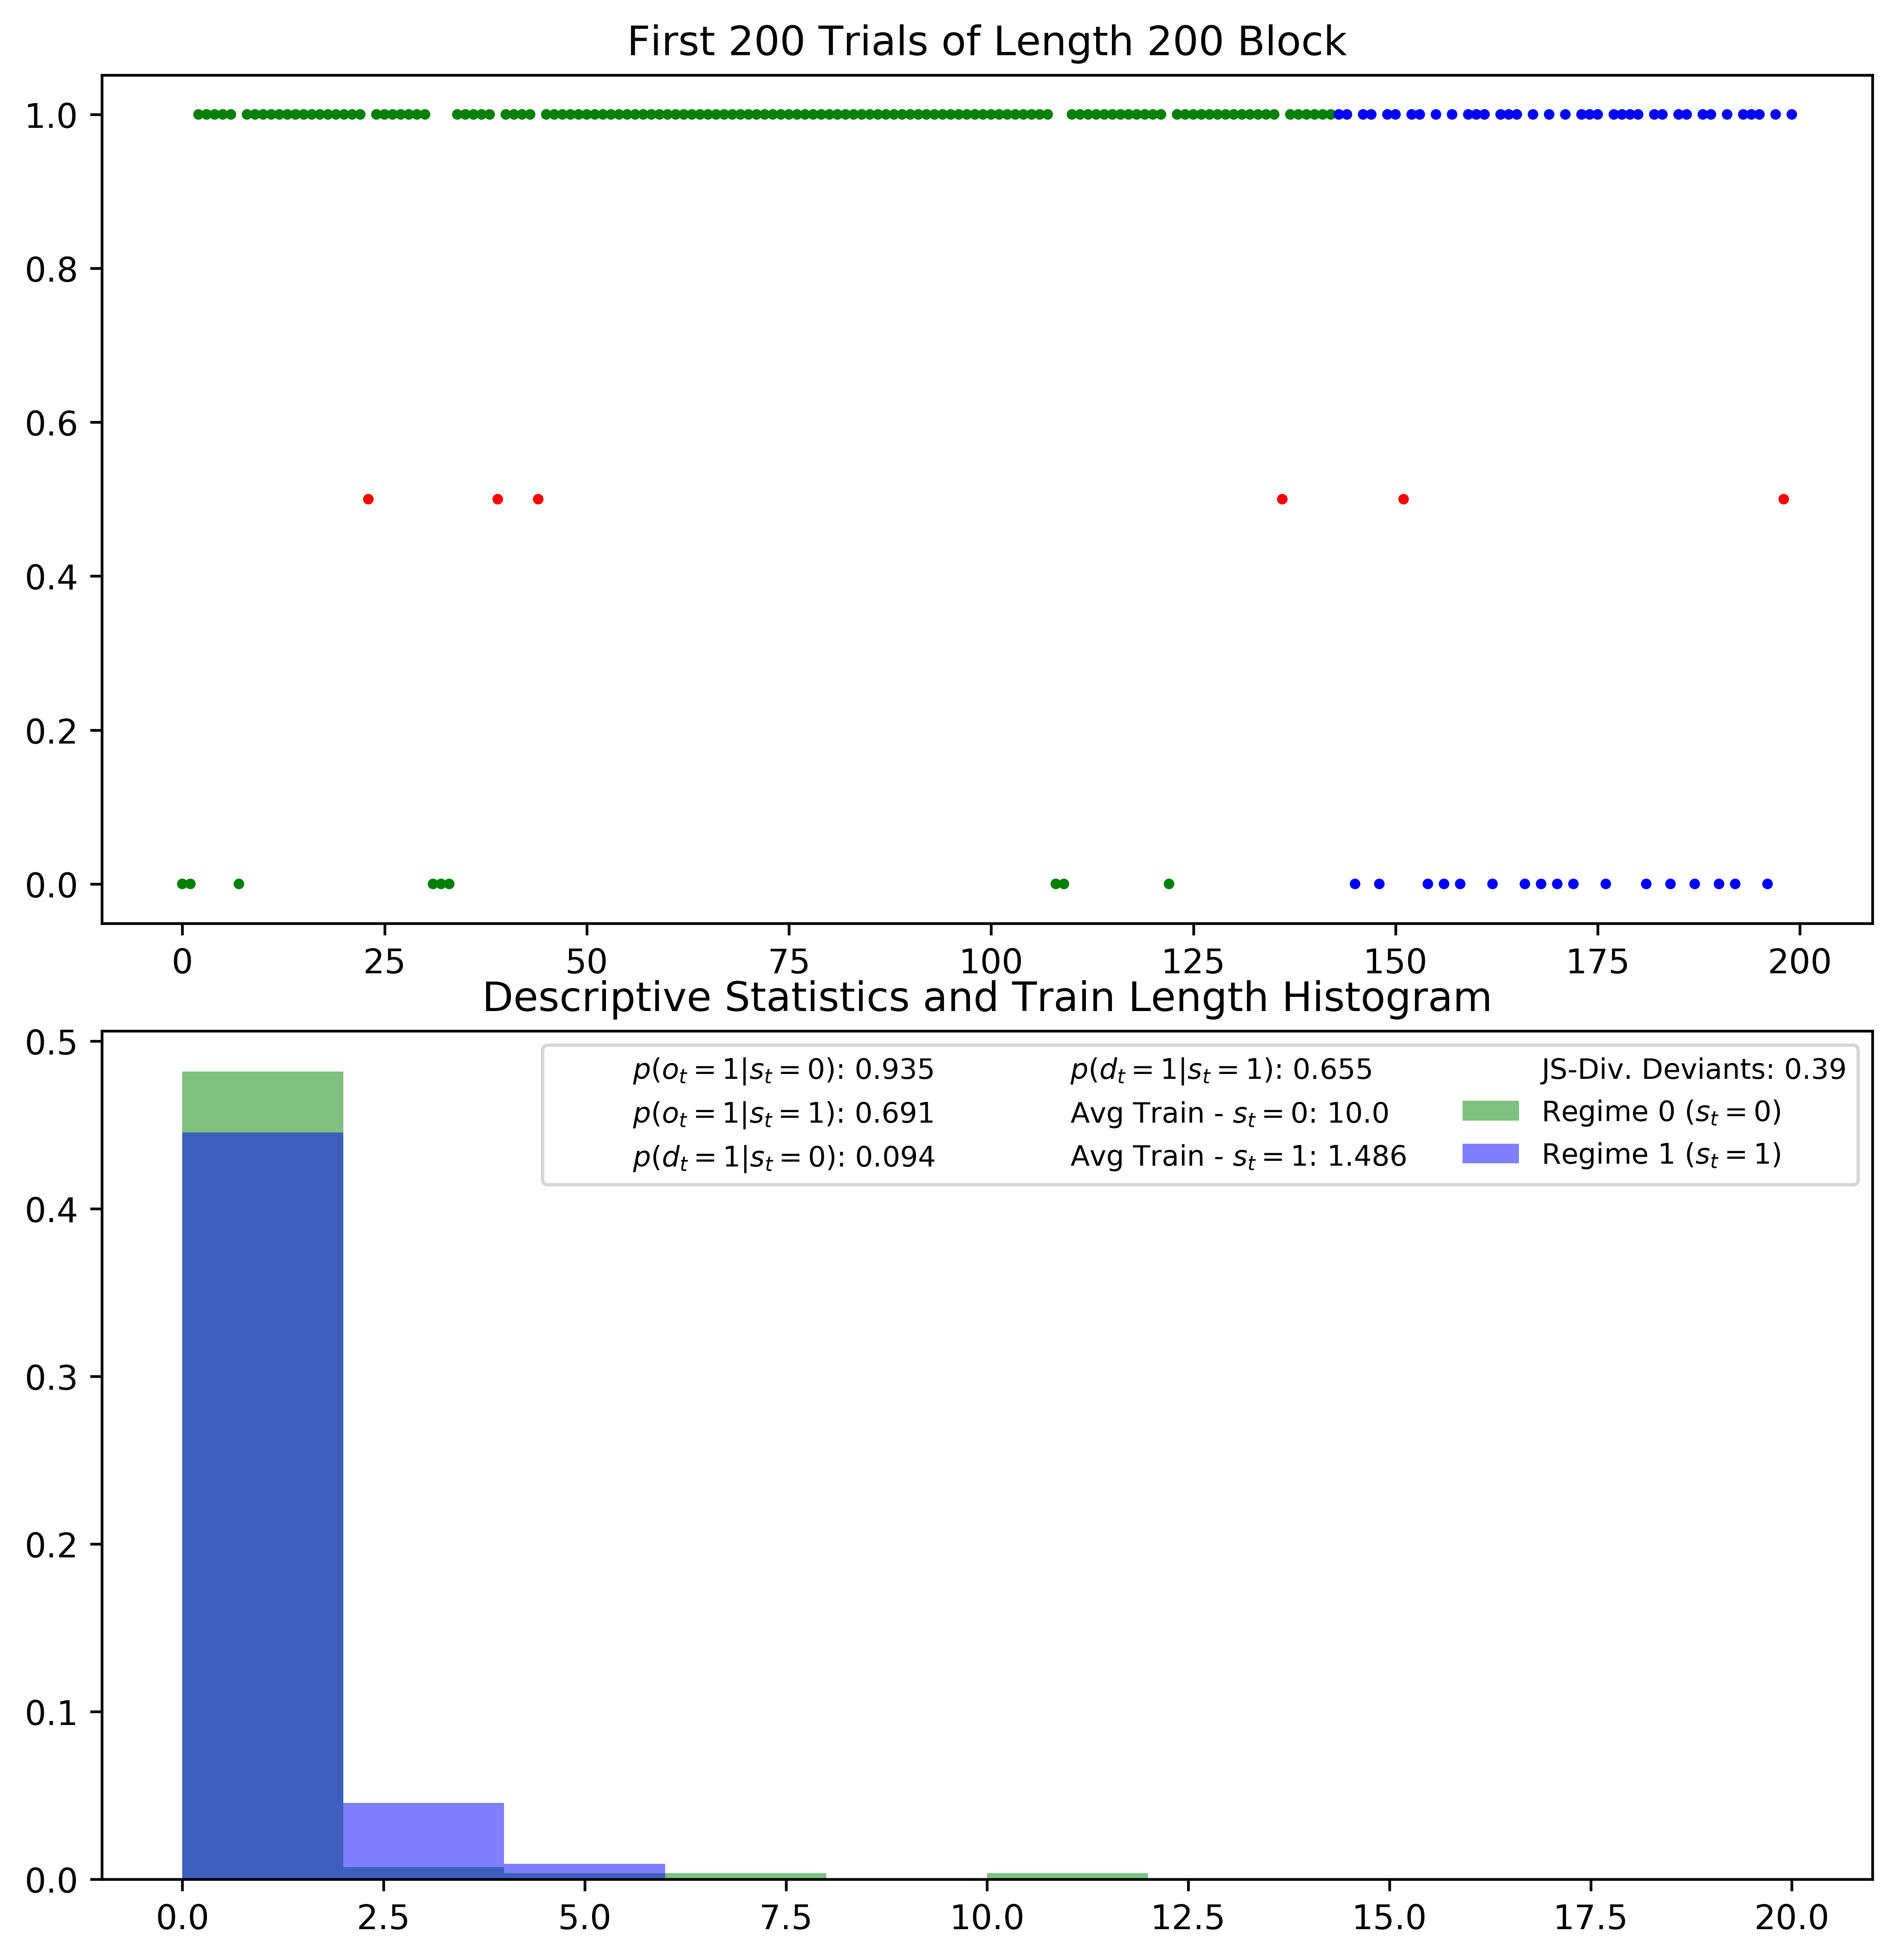

In [23]:
# sequence = gen_temp.sample(seq_length)
# Plot the sampled sequence - when exec from command line
sg.sample_and_save(gen_temp, seq_length, sample_file,
                   matlab_out, plot_seq)

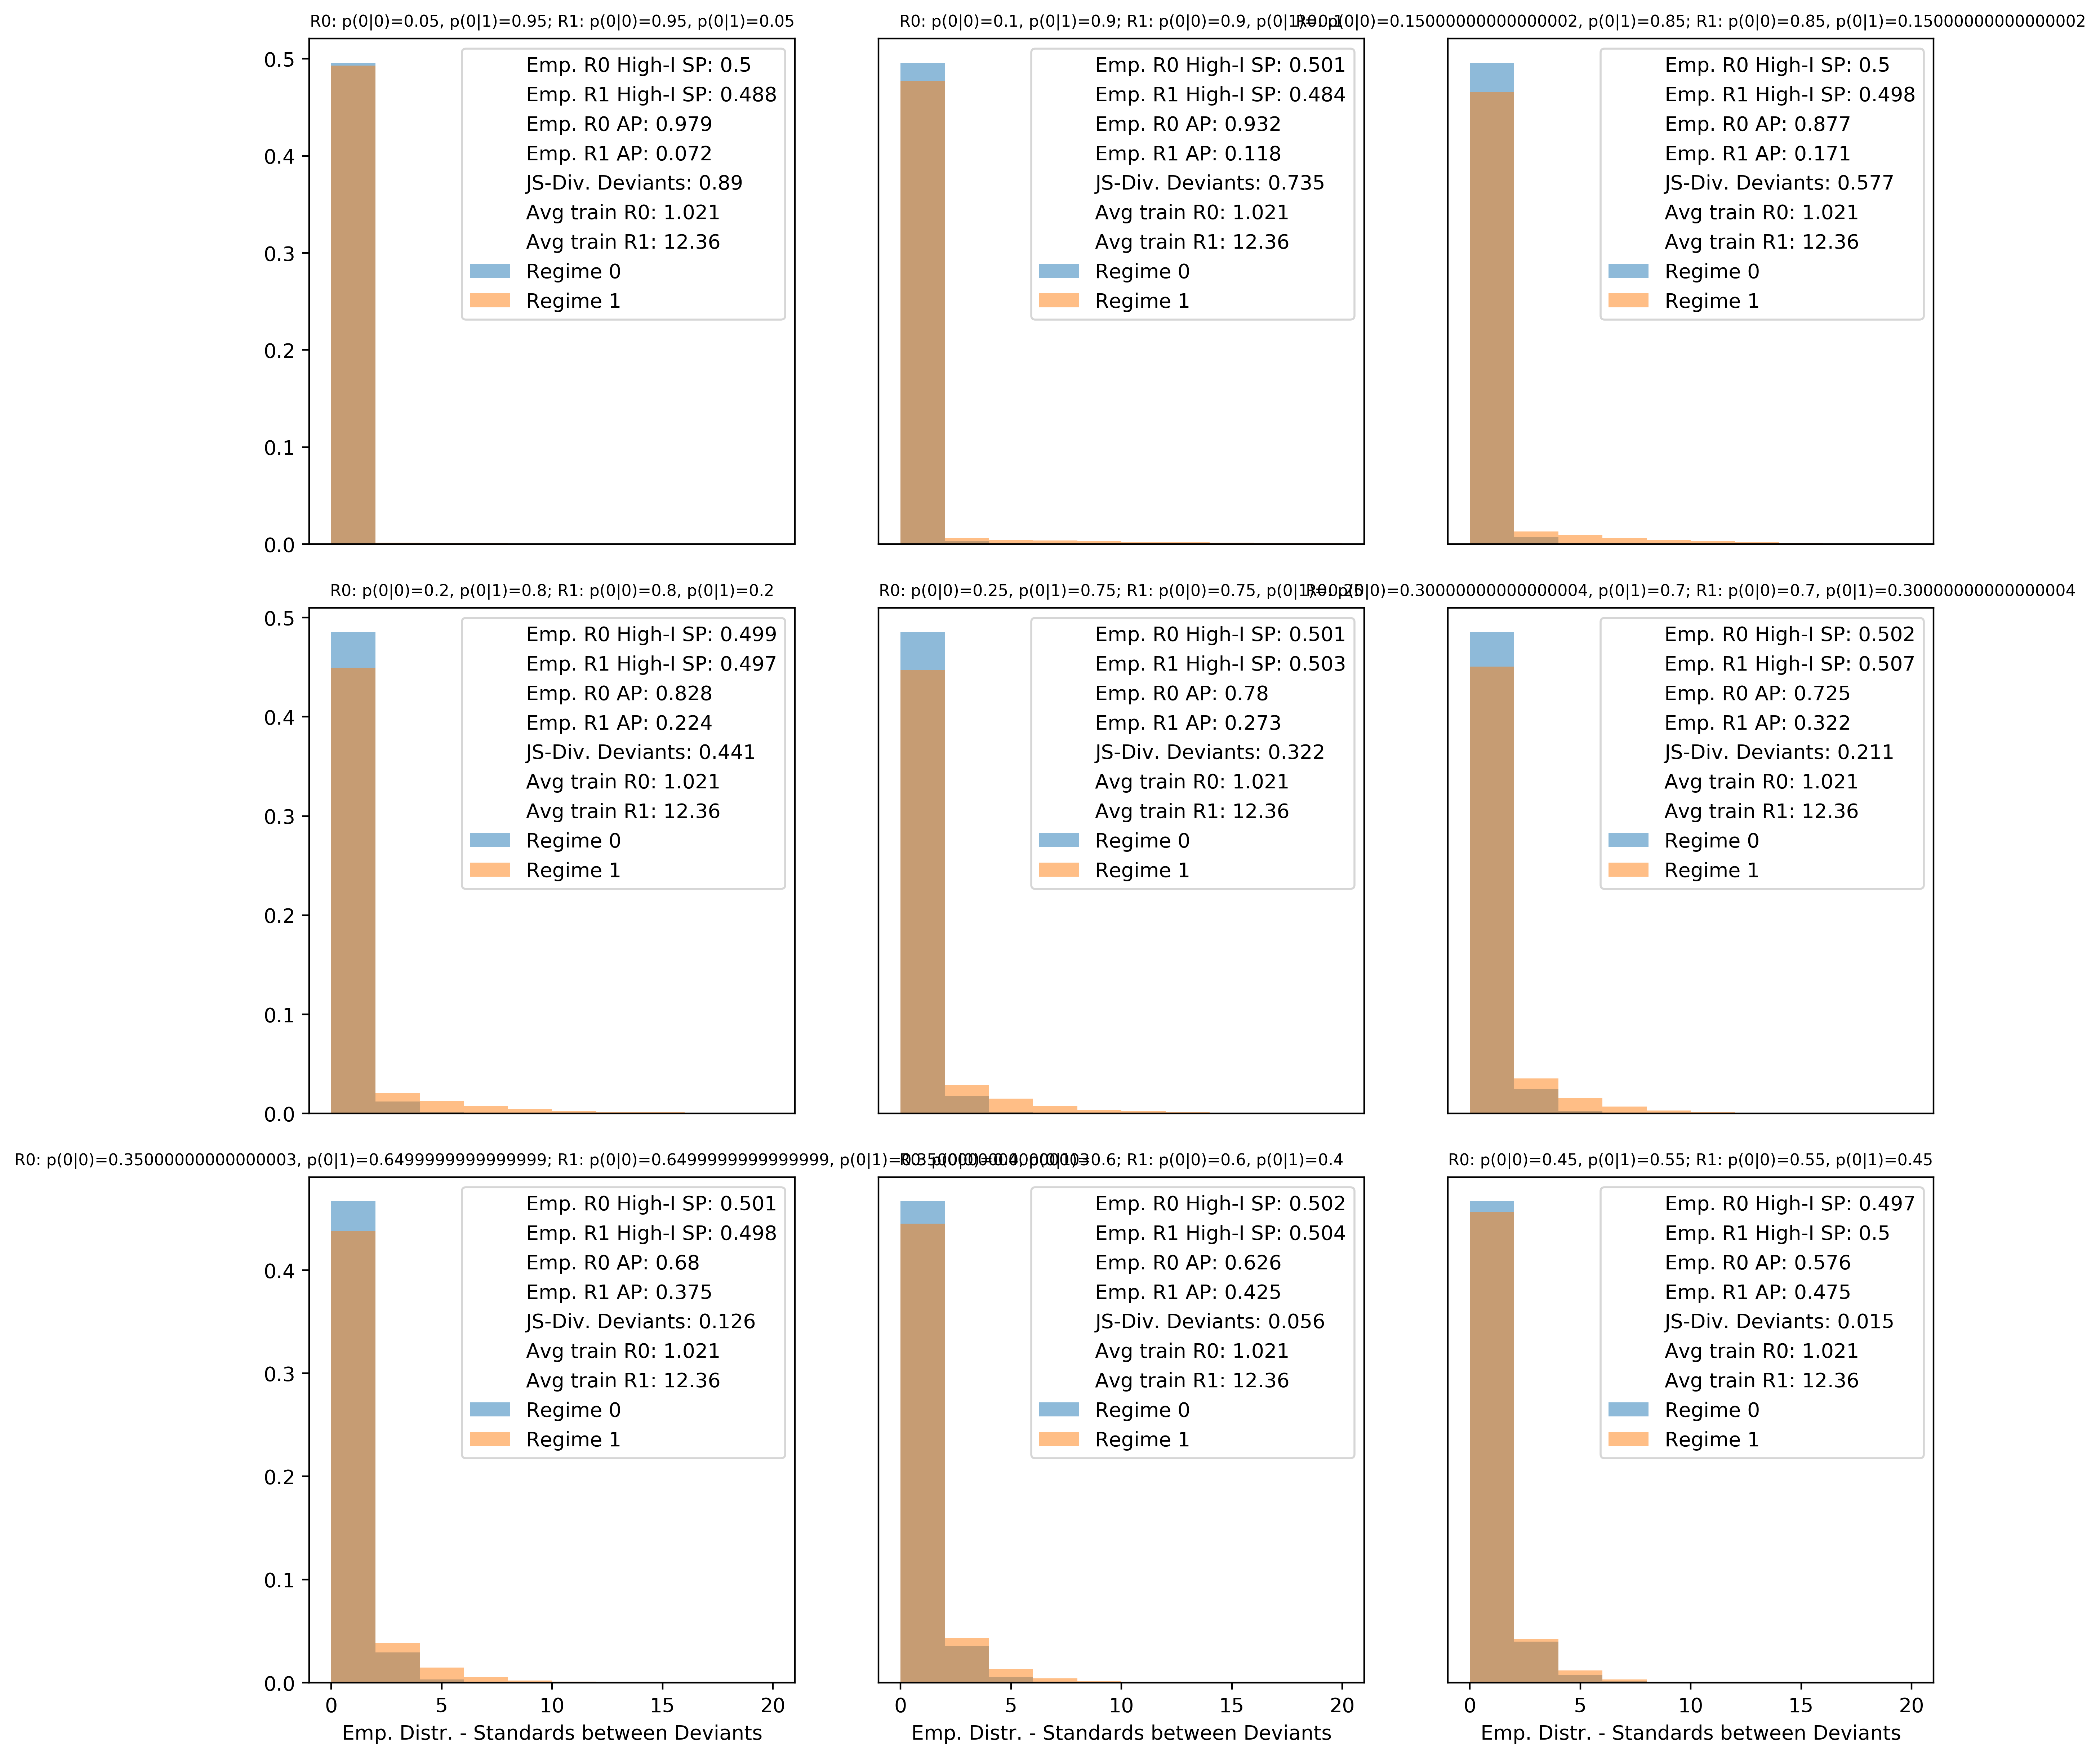

In [24]:
if plot_seqs:
    sa.main(order=1, verbose=False, plot=True, save=False)

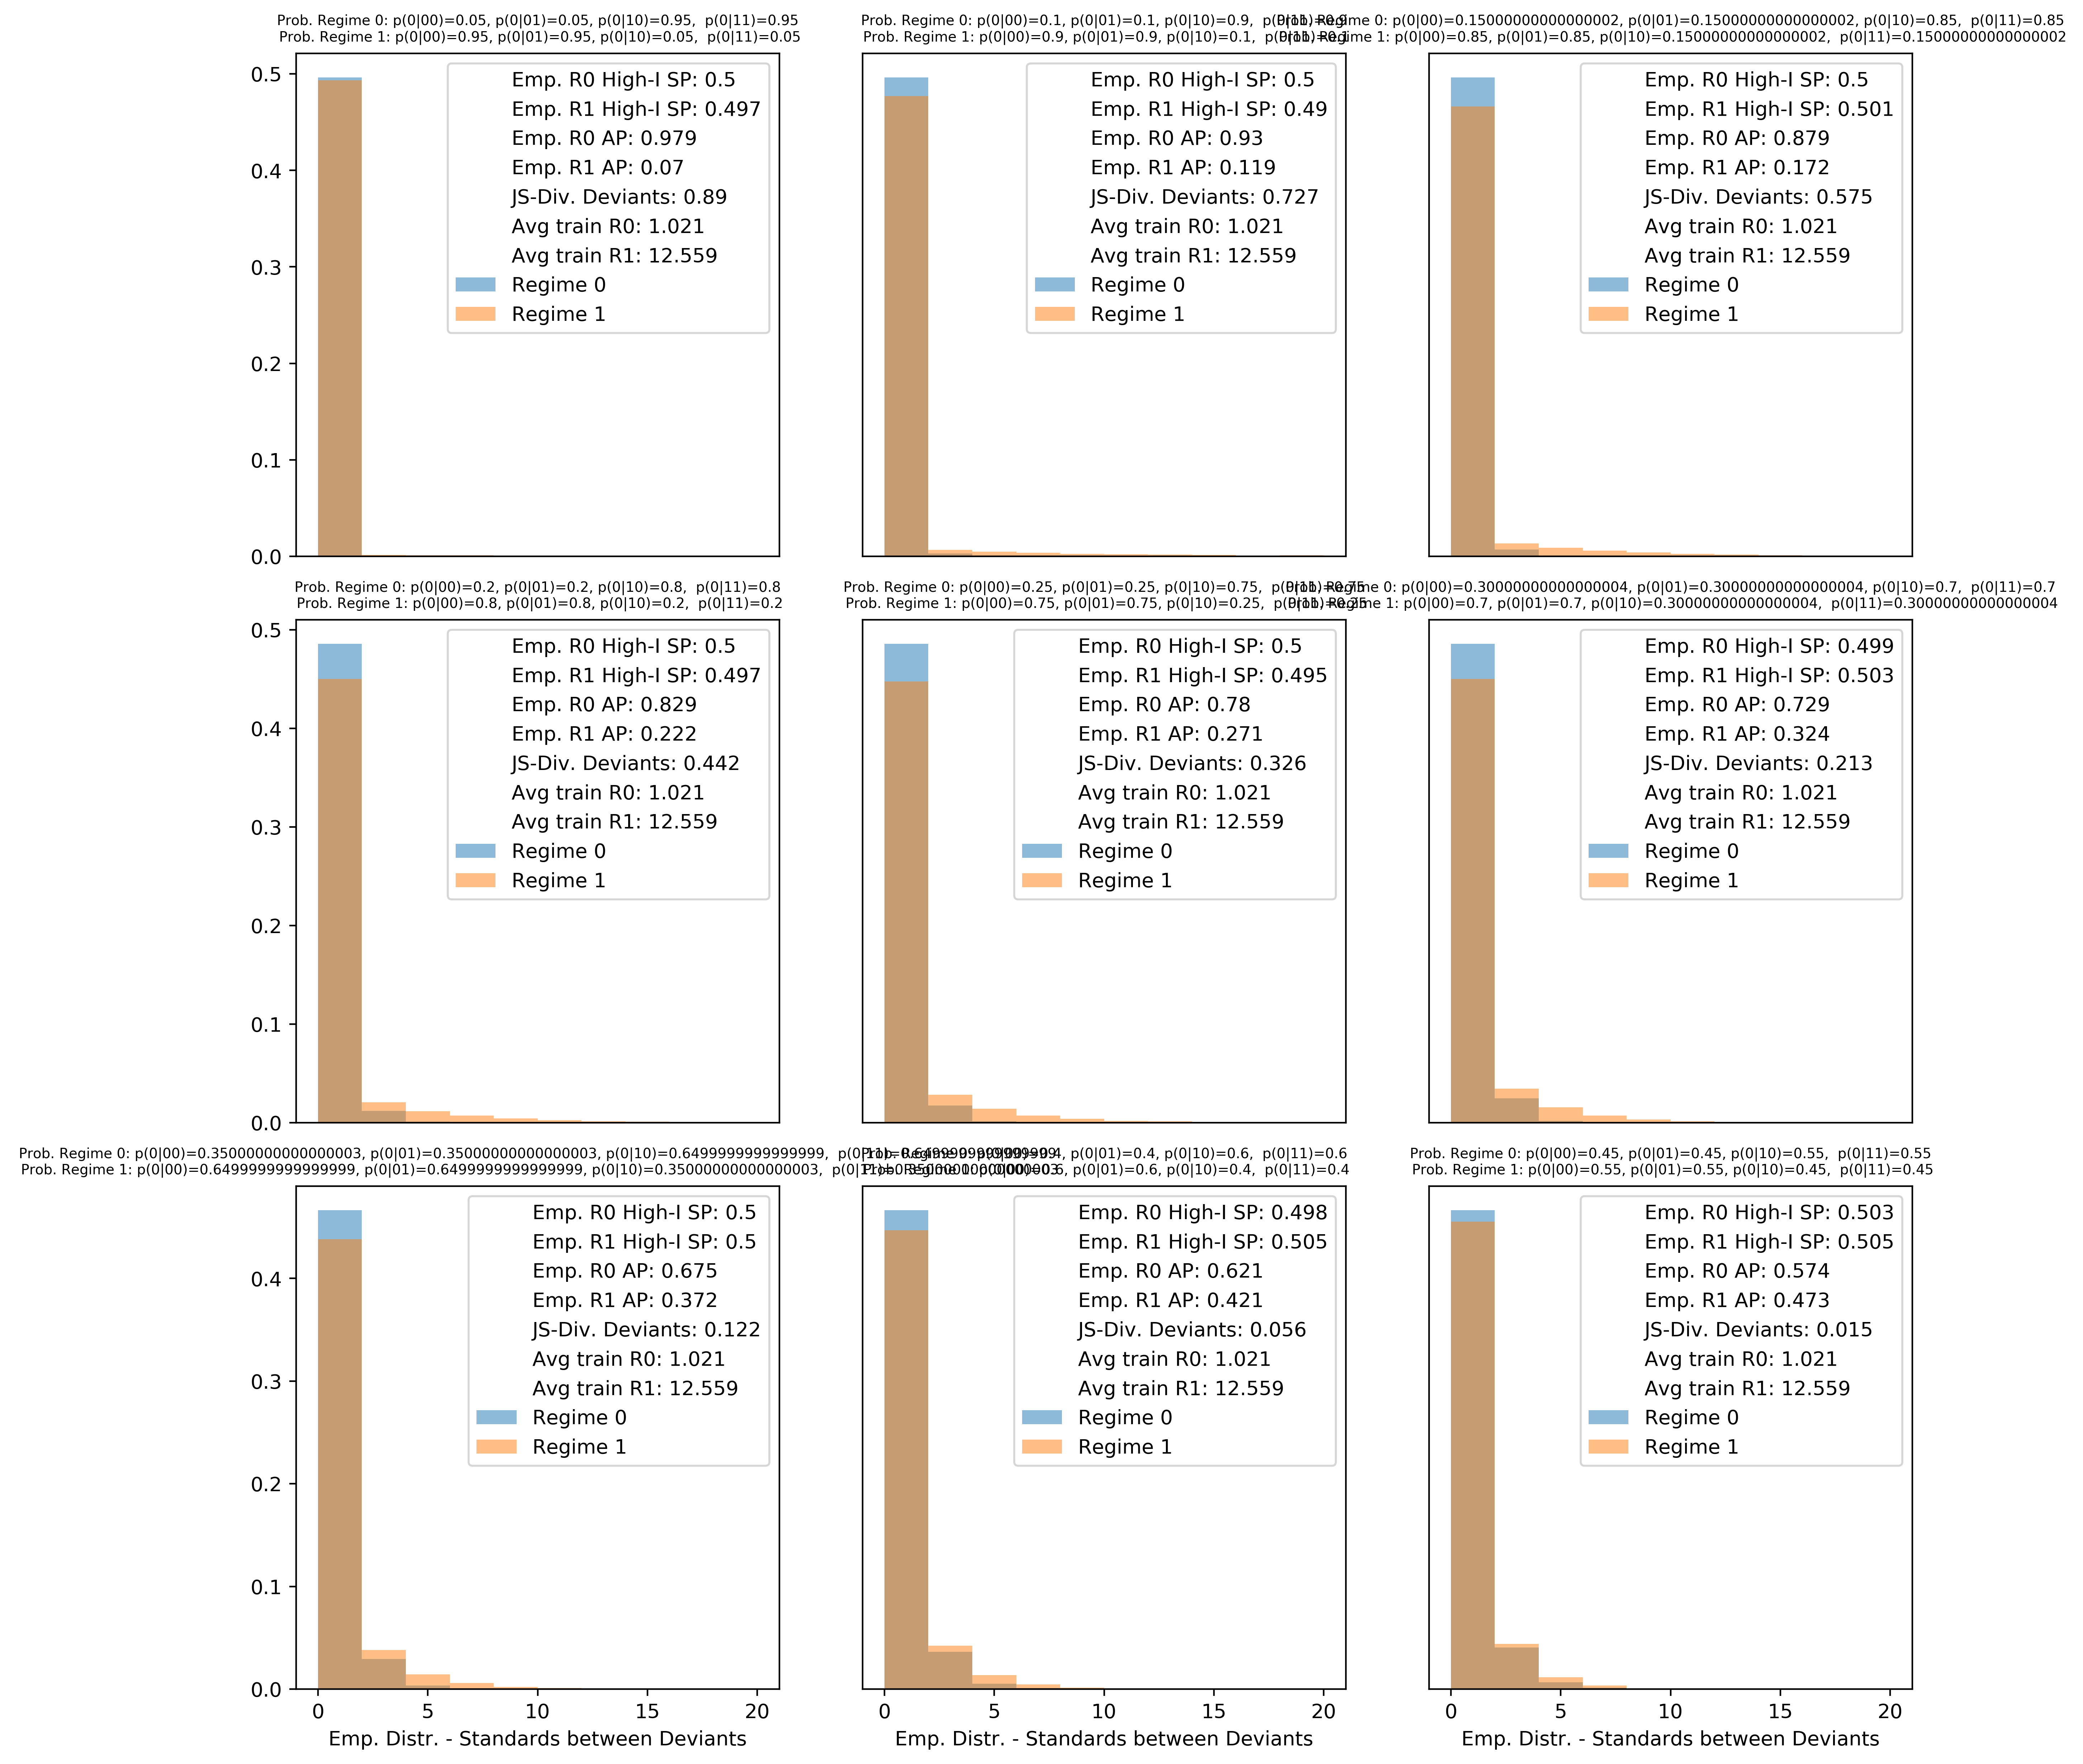

In [25]:
if plot_seqs:
    sa.main(order=2, verbose=False, plot=True, save=False)

# 2. Modeling of different Sequential Bayesian Learning Agents

In [28]:
# Import relevant SBL modules
import sbl_agents.sbl_cat_dir as sbl_cd
import sbl_agents.sbl_hmm as sbl_hmm

SyntaxError: invalid syntax (sbl_cat_dir.py, line 57)

In [ ]:
sample_files = ["sub-01_ses-1_run-1", "sub-01_ses-1_run-2",
                "sub-01_ses-1_run-3", "sub-01_ses-1_run-4",
                "sub-01_ses-1_run-5"]
sample = load_obj(results_dir + "S1_800" + ".mat")

In [ ]:
seq = sample["sample_output"][:, 2]
hidden = sample["sample_output"][:, 1]

prob_regime_init = sample["prob_regime_init"]
prob_obs_init = sample["prob_obs_init"]
prob_obs_change = sample["prob_obs_change"]
prob_regime_change = sample["prob_regime_change"]

In [ ]:
# General Model Settings
model_types = ["SP", "AP", "TP"]
save_results = True
verbose = True

## 2.1. Conjugate Categorical-Dirichlet Model

In [ ]:
tau = 0.

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_cd.test_agent(seq, hidden, tau, model, verbose)

In [ ]:
for model in model_types:
    sbl_cd.main(seq, hidden, tau, model,
                prob_regime_init, prob_obs_init, prob_obs_change,
                prob_regime_change,
                save_results, title="CD_" + model + "_" + sample_file,
                verbose=True)

In [ ]:
SP_CD = load_obj(results_dir + "CD_" + "SP" + "_" + sample_file + ".pkl")
AP_CD = load_obj(results_dir + "CD_" + "AP" + "_" + sample_file + ".pkl")
TP_CD = load_obj(results_dir + "CD_" + "TP" + "_" + sample_file + ".pkl")

In [ ]:
plot_surprise(SP_CD, AP_CD, TP_CD, title=r"Categorical-Dirichlet ($\tau = 0$)",
                  save_pic=False)

## 2.2. Hidden Markov Model

In [ ]:
n_states = 2

In [ ]:
# Test agents by calculating posterior after 3 timesteps
# and Surprises for t=1,2,3
for model in model_types:
    sbl_hmm.test_agent(seq, hidden, n_states, model, verbose)

## 3. Model Comparison across Different SBL Agents and Surprise Regressors